# Enunciado

Intenta aplicar lo aprendido con las lecciones de ingeniería de propiedades con el conjunto de datos de Titanic disponible en Kaggle. Este dataset es accesible y contiene una mezcla de tipos de datos categóricos y numéricos, lo que lo hace perfecto para ejercitar diversas técnicas de ingeniería de propiedades. La tarea consiste en predecir la supervivencia de los pasajeros del Titanic utilizando machine learning.

Tareas Específicas:

1. Análisis Exploratorio de Datos (EDA): Buscar valores faltantes e identifica las posibles relaciones entre las características y la variable objetivo.

2. Limpieza de Datos: Basándose en el EDA debes tratar los valores faltantes y corregir posibles errores en los datos

3. Construye un modelo base para poder comparar sus resultados con otros después de aplicar ingeniería de propiedades.

4.  Elimina las características irrelevantes y prueba el modelo, si no hay mejora no las quites. 

5. Aplicar técnicas de ingeniería de propiedades para transformar y crear nuevas características. Algunas sugerencias:

Crea una característica de "Tamaño de la familia" sumando las características SibSp (número de hermanos/cónyuges a bordo) y Parch (número de padres/hijos a bordo).
Extrae el título de la característica Name y usarlo para crear una nueva característica que pueda indicar el estatus social o el género, lo que podría influir en la supervivencia.
Crea bandas de edad para transformar la edad en una característica categórica, facilitando la captura de relaciones no lineales con la supervivencia.
Aplica target encoding a la característica Cabin considerando la letra de la cabina como una indicación de la cubierta, lo que podría afectar las posibilidades de supervivencia.
Prueba con random forest.

## Cargamos los datos

In [83]:
# Cargar datos del Titanic
import pandas as pd

train, validation = pd.read_csv('csv/train.csv'), pd.read_csv('csv/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Análisis Exploratorio de Datos (EDA)

In [84]:
# Información de los datos
print(f"Cantidad de filas y columnas: {train.shape}\n=======================================") # Muestra la cantidad de filas y columnas
train.info() # Muestra información de las columnas y los tipos de datos

Cantidad de filas y columnas: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Valores faltantes

In [85]:
# Tabla de valores faltantes (Columnas, Cantidad de valores totales, Cantidad de valores faltantes)
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = pd.DataFrame({'Columna': missing_values.index, 'Cantidad de valores totales': train.shape[0], 'Cantidad de valores faltantes': missing_values.values})
print(missing_values)

    Columna  Cantidad de valores totales  Cantidad de valores faltantes
0       Age                          891                            177
1     Cabin                          891                            687
2  Embarked                          891                              2


Como podemos observar, las columnas `Age`, `Cabin` y `Embarked` tienen valores faltantes. Vamos a tratar estos valores faltantes. Para la columna `Age` vamos a reemplazar los valores faltantes por la mediana de la columna. Para la columna `Embarked` vamos a reemplazar los valores faltantes por la moda de la columna. La columna `Cabin` vamos a eliminarla ya que tiene muchos valores faltantes.

In [86]:
# Reemplazar valores faltantes
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
train = train.drop('Cabin', axis=1)

Ahora vamos a transformar las variables categóricas a numéricas con OneHotEncoder. La columna `Name` la vamos a transformar en una nueva columna `Title` que va a contener el título de la persona. La columna `Ticket` la vamos a eliminar ya que no aporta información relevante.

In [87]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Eliminar la columna 'Ticket'
train.drop('Ticket', axis=1, inplace=True)

# Extraer el título de la columna 'Name' y crear la columna 'Title'
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Reemplazar títulos raros por 'Rare'
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

# Reemplazar títulos en otros idiomas por su traducción en inglés
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

# Eliminar la columna 'Name'
train.drop('Name', axis=1, inplace=True)

# Seleccionar las columnas categóricas
categorical_columns = train.select_dtypes(include=['object'])

# Crear un objeto OneHotEncoder
encoder = OneHotEncoder()

# Ajustar y transformar las columnas categóricas
encoded_columns = encoder.fit_transform(categorical_columns)

# Obtener los nombres de las características
feature_names = encoder.get_feature_names_out(categorical_columns.columns)

# Crear un DataFrame con las columnas transformadas
encoded_columns_df = pd.DataFrame(encoded_columns.toarray(), columns=feature_names)

# Concatenar las columnas transformadas con el conjunto de datos original
train_encoded = pd.concat([train.drop(categorical_columns.columns, axis=1), encoded_columns_df], axis=1)

train_encoded.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,4,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,5,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Relaciones entre características y la variable objetivo

In [88]:
# Definimos el conjunto de entrenamiento y la variable objetivo
X = train_encoded.drop('Survived', axis=1)
y = train_encoded['Survived']

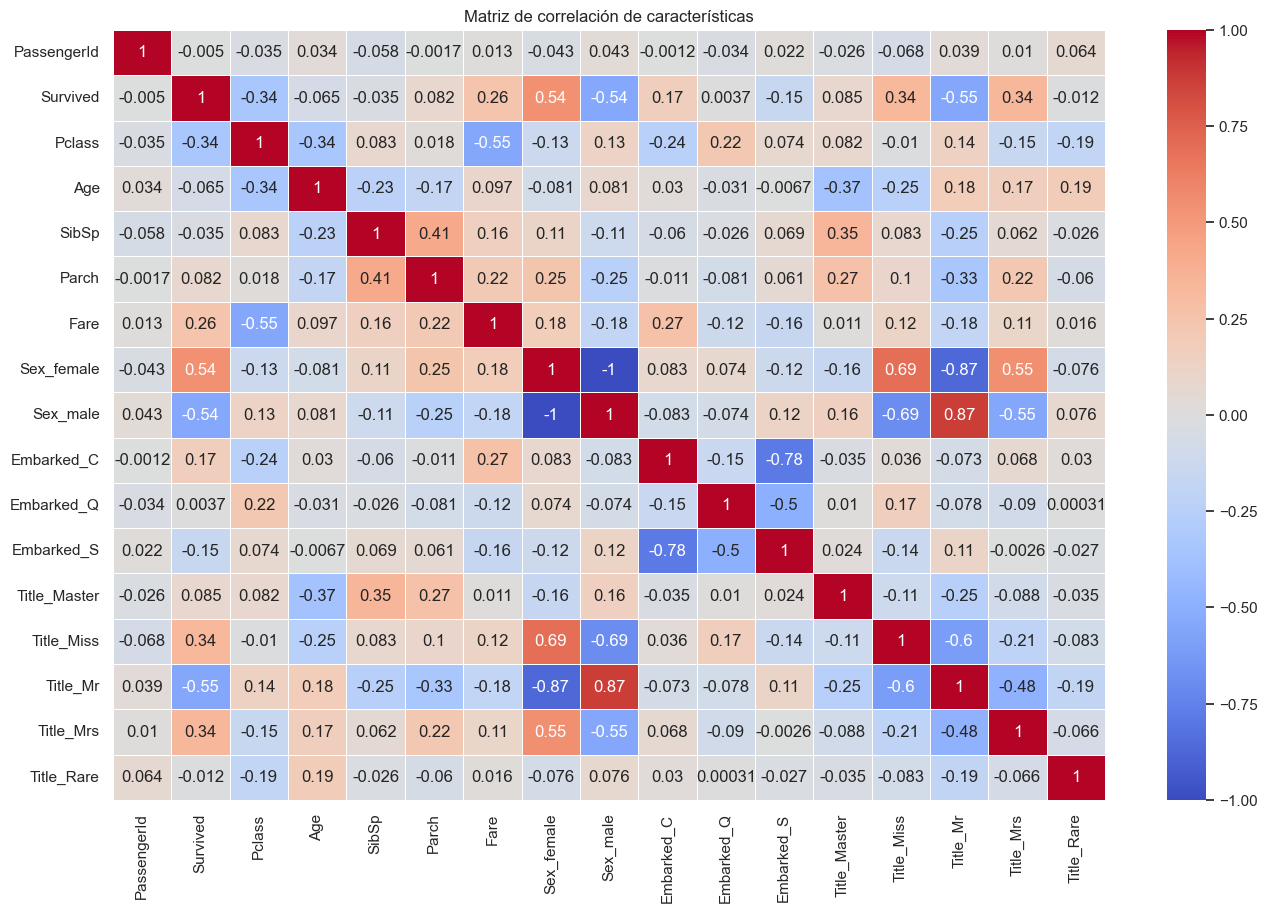

In [89]:
# Importa las bibliotecas necesarias
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las columnas numéricas en X
numeric_columns = train_encoded.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación solo para las columnas numéricas
correlation_matrix = numeric_columns.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación de características')
plt.show()

Con esta información podemos ver si hay alguna relación entre las características y la variable objetivo. En este caso, la variable `Survived` no tiene una correlación muy alta con las variables `PassengerId`, `Embarked_Q`. Vamos a realizar un primer modelo con todas las características y luego vamos a eliminar las características irrelevantes para ver si hay alguna mejora.

## Construcción del modelo   

### Preparación del conjunto de datos

In [90]:
from sklearn.model_selection import train_test_split

p_train = 0.7

train, test = train_test_split(train_encoded, train_size=p_train, random_state=42)

# inplace=True: Modifica el dataframe original en lugar de devolver uno nuevo
train.reset_index(inplace=True)
test.reset_index(inplace=True)

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

print("Conjunto de entrenamiento:")
print(train.head())

print("Conjunto de prueba:")
print(test.head())

Train: (623, 18)
Test: (268, 18)
Conjunto de entrenamiento:
   index  PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  \
0    445          446         1       1   4.0      0      2  81.8583   
1    650          651         0       3  28.0      0      0   7.8958   
2    172          173         1       3   1.0      1      1  11.1333   
3    450          451         0       2  36.0      1      2  27.7500   
4    314          315         0       2  43.0      1      1  26.2500   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Title_Master  \
0         0.0       1.0         0.0         0.0         1.0           1.0   
1         0.0       1.0         0.0         0.0         1.0           0.0   
2         1.0       0.0         0.0         0.0         1.0           0.0   
3         0.0       1.0         0.0         0.0         1.0           0.0   
4         0.0       1.0         0.0         0.0         1.0           0.0   

   Title_Miss  Title_Mr  Title_Mrs  Title_Ra

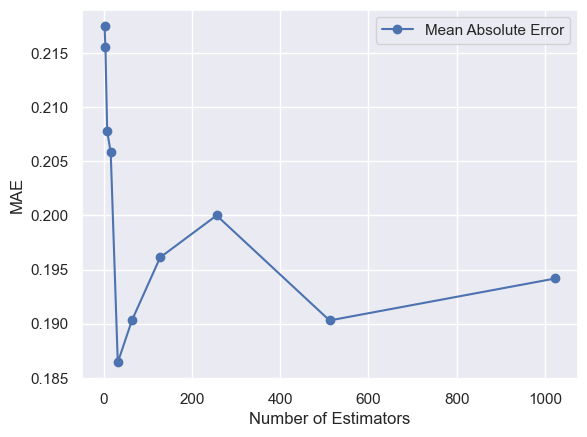

In [91]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

cv = TimeSeriesSplit()

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []

for estimators in l_estimators:
    fold_errors = []  # fold_errors para modelo de clasificación, fold_accuracies para modelo de regresión
    classifier = RandomForestClassifier(n_estimators=estimators,
                                        criterion="entropy",
                                        random_state=42)
    for train_fold, test_fold in cv.split(train):
        
        # División train test aleatoria
        f_train = train.loc[train_fold]
        f_test = train.loc[test_fold]
        
        # Entrenamiento y ejecución del modelo
        classifier.fit(X=f_train.drop(['Survived'], axis=1),
                       y=f_train['Survived'])
        y_pred = classifier.predict(X=f_test.drop(['Survived'], axis=1))
        
        # Evaluación del modelo
        mae = mean_absolute_error(f_test['Survived'], y_pred)
        fold_errors.append(mae)

    total_scores.append(sum(fold_errors) / len(fold_errors))

plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')
plt.xlabel('Number of Estimators')
plt.legend(['Mean Absolute Error'])
plt.show()

In [92]:
import numpy as np
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 32, MAE =   0.19)


In [93]:
classifier = RandomForestClassifier(n_estimators=best_est,
                                    criterion="entropy",
                                    random_state=42)

classifier.fit(X=train.drop(['Survived'], axis=1),
                y=train['Survived'])

y_pred = classifier.predict(X=test.drop(['Survived'], axis=1))

In [98]:
# Error del modelo
mae = mean_absolute_error(test['Survived'], y_pred)
print(f"Error: {mae}")

# Precisión del modelo
accuracy = classifier.score(X=test.drop(['Survived'], axis=1), y=test['Survived'])
print(f"Precisión: {accuracy}")

Error: 0.1865671641791045
Precisión: 0.8134328358208955


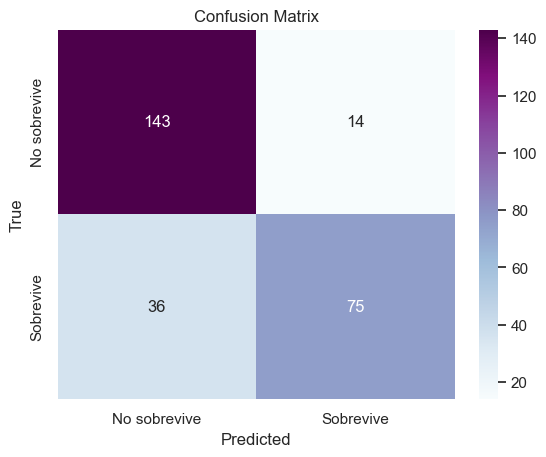

In [96]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test["Survived"], y_pred)
classes = ['No sobrevive', 'Sobrevive']
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Eliminación de características irrelevantes

Ahora vamos a eliminar las características irrelevantes y ver si hay alguna mejora en el modelo.

In [99]:
# Eliminar las características irrelevantes
train_encoded = train_encoded.drop(['PassengerId', 'Embarked_Q'], axis=1)

### Preparación del conjunto de datos

In [100]:
from sklearn.model_selection import train_test_split

p_train = 0.7

train, test = train_test_split(train_encoded, train_size=p_train, random_state=42)

# inplace=True: Modifica el dataframe original en lugar de devolver uno nuevo
train.reset_index(inplace=True)
test.reset_index(inplace=True)

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

print("Conjunto de entrenamiento:")
print(train.head())

print("Conjunto de prueba:")
print(test.head())

Train: (623, 16)
Test: (268, 16)
Conjunto de entrenamiento:
   index  Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
0    445         1       1   4.0      0      2  81.8583         0.0       1.0   
1    650         0       3  28.0      0      0   7.8958         0.0       1.0   
2    172         1       3   1.0      1      1  11.1333         1.0       0.0   
3    450         0       2  36.0      1      2  27.7500         0.0       1.0   
4    314         0       2  43.0      1      1  26.2500         0.0       1.0   

   Embarked_C  Embarked_S  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0         0.0         1.0           1.0         0.0       0.0        0.0   
1         0.0         1.0           0.0         0.0       1.0        0.0   
2         0.0         1.0           0.0         1.0       0.0        0.0   
3         0.0         1.0           0.0         0.0       1.0        0.0   
4         0.0         1.0           0.0         0.0       1.0        0.0 

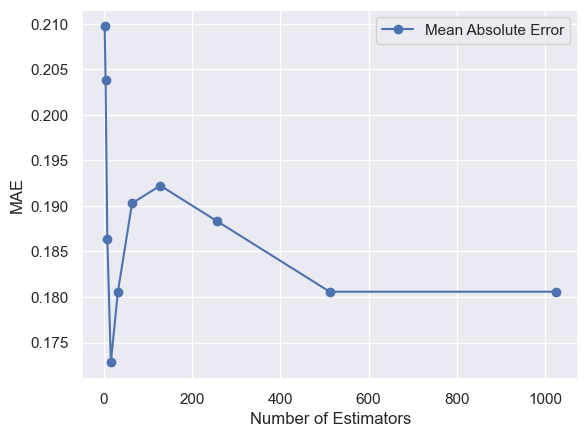

In [101]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

cv = TimeSeriesSplit()

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []

for estimators in l_estimators:
    fold_errors = []  # fold_errors para modelo de clasificación, fold_accuracies para modelo de regresión
    classifier = RandomForestClassifier(n_estimators=estimators,
                                        criterion="entropy",
                                        random_state=42)
    for train_fold, test_fold in cv.split(train):
        
        # División train test aleatoria
        f_train = train.loc[train_fold]
        f_test = train.loc[test_fold]
        
        # Entrenamiento y ejecución del modelo
        classifier.fit(X=f_train.drop(['Survived'], axis=1),
                       y=f_train['Survived'])
        y_pred = classifier.predict(X=f_test.drop(['Survived'], axis=1))
        
        # Evaluación del modelo
        mae = mean_absolute_error(f_test['Survived'], y_pred)
        fold_errors.append(mae)

    total_scores.append(sum(fold_errors) / len(fold_errors))

plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')
plt.xlabel('Number of Estimators')
plt.legend(['Mean Absolute Error'])
plt.show()

In [102]:
import numpy as np
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 16, MAE =   0.17)


In [103]:
classifier = RandomForestClassifier(n_estimators=best_est,
                                    criterion="entropy",
                                    random_state=42)

classifier.fit(X=train.drop(['Survived'], axis=1),
                y=train['Survived'])

y_pred = classifier.predict(X=test.drop(['Survived'], axis=1))

In [104]:
# Error del modelo
mae = mean_absolute_error(test['Survived'], y_pred)
print(f"Error: {mae}")

# Precisión del modelo
accuracy = classifier.score(X=test.drop(['Survived'], axis=1), y=test['Survived'])
print(f"Precisión: {accuracy}")

Error: 0.19029850746268656
Precisión: 0.8097014925373134


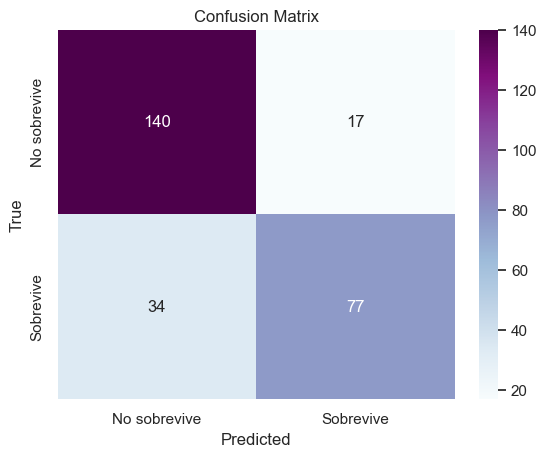

In [105]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test["Survived"], y_pred)
classes = ['No sobrevive', 'Sobrevive']
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Conclusiones

En este caso, la eliminación de las características irrelevantes no mejoró el modelo. Por lo tanto, es importante realizar un análisis detallado de las características antes de eliminarlas. Además, se pueden probar diferentes técnicas de ingeniería de propiedades para mejorar el rendimiento del modelo.